### THE BRIDGE  - Data Science Bootcamp  
## `Clasificación de Lesiones Cutáneas usando una Red Neuronal Convolucional (CNN) y Data Augmentation`

#### Mónica Villasuso López -  Proyecto Final (Octubre 2020)


Referencias consultadas (para Data Augmentation):  
https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
https://datasmarts.net/es/como-usar-imagedatagenerator-para-entrenar-una-cnn-en-keras/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/convnets_aumentadas/convnets_aumentadas.html


Sociedad Americana contra el Cancer
https://www.cancer.org/es/


## Antecedentes. Contexto  
=================================  
La escogencia del proyecto final está relacionada con:  
1) La necesidad de un proyecto personal donde se pudieran consolidar los conocimientos adquiridos durante la segunda parte del bootcamp (Analítica Avanzada - Machine Learning y Deep Learning).  
2) La evaluación de alternativas y la disponibilidad de datos o información para llevarlas a cabo,   
3) Un proyecto que además de académico me generara un interés particular, con lo cual la motivación para encararlo sería mayor.  

Por otro lado, personalmente siempre he tenido la preocupación por el daño que las radiaciones solares (y más aún en los últimos años) pueden generar en la piel. Es una realidad que en muchos casos este daño puede ser mortal (de hecho tengo dos referencias cercanas que han fallecido por esta razón) pero es también una realidad que este daño se puede minimizar, y mucho, si se hace un diagnóstico temprano.
Son muchas las fuentes y publicaciones que hacen referencia a la revisión personal de las lesiones cutáneas siguiendo una regla básica.   
La **“Regla del ABCDE”** es recomendada para buscar algunos de los signos comunes de melanoma, que es una de las formas más mortales del cáncer de piel. Según esta regla hay que observar:    

A - **A**simetría  
Una parte de un lunar o mancha de nacimiento (angioma) no es igual a la otra.  
B - **B**orde  
Los bordes son irregulares, desiguales, con rebordes, o borrosos.  
C - **C**olor  
El color no es el mismo en todos lados y puede incluir matices de marrón o negro, a veces con zonas de color rosado, rojo, blanco o azul.  
D - **D**iánetro  
El lunar es más grande de ¼ de pulgada (0.6 cm) de ancho (aproximadamente el tamaño del borrador de un lápiz) aunque en ocasiones los melanomas podrían ser menores a este tamaño.  
E - **E**volución:   
El lunar está cambiando en cuanto a tamaño, forma o color.  

Debido a que muchas de estas señales eran visibles y detectables a través de una imagen, surgió la idea de validar si con un modelo de aprendizaje supervisado y entrenando una Red Neuronal Convolucional se podría llegar a una predicción. El resultado de la predicción tendría que ver con la posibilidad de que la lesión fuese ** Sospechosa ** (en cuyo caso se recomienda la revisión por un especialista) o ** Normal** .  

Las fases del proyecto se planificaron de la siguiente manera:  
1) Recolección de datos  
2) Preparación de datos  
3) Entrenamiento de varios modelos  
4) Selección del mejor modelo y entonación de parámetros  
5) Pruebas finales y conclusiones  

## Carga de Datos  
=================================  
Debido a que se trata de un caso de Aprendizaje supervisado, los datos se encuentran bien diferenciados y almacenados en directorios separados según la categorización. Para este problema se han dividido en:  
* Malignos: Fotografías de lunares, manchas o lesiones de la piel que luego de ser estudiadas han sido diagnosticadas como * Malignas (Sospechosas) *  , es decir, con algún tipo de melanoma o condición que amerite tratamiento con un especialista  

* Benignos: Fotografías de lunares, manchas o lesiones de la piel que luego de ser estudiadas han sido diagnosticadas como * Benignas (Normales) *  sin que ameriten especial revisión médica.


### `TOMA IMAGENES YA CONVERTIDAS A BLANCO Y NEGRO Y REDIMENSIONADAS`

Imports

In [1]:
# Manejo de archivos y directorios
import os
from os import listdir
from os.path import isfile, join
import time
sys.path.append("../src/utils")

# Básicas (álgebra, números aleatorios, carga de datos en dataframe, visualizacion)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import shuffle

# Manejo de imágenes
import imageio
import cv2

# Guardar los modelos
import json

# Analítica Avanzada
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Redes Neuronales 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,img_to_array


#Modulos del proyecto
from utils import apis_tb as a_tb
from utils import folders_tb as f_tb
from utils import models_tb as mod_tb
from utils import mining_data_tb as m_tb
from utils import visualization_tb as v_tb

In [2]:
my_path = os.getcwd()  #Guarda en esta variable el path inicial del main del proyecto
SEED = 54

### (1) Preprocesamiento de las imágenes

In [4]:
gray_folder = "gray"
resize_folder = "resize"
benig_rel_path ="../resources/Benignos" 
malig_rel_path = "../resources/Malignos"
# Nombres de las clases (target)
class_names = ['Maligno','Benigno']  # (0=Maligno, 1=Benigno)

#### Crear directorios con las imágenes en Blanco y Negro y redimensionadas para el análisis    
`NOTA: Sólo debe ejecutarse una vez. Luego de que las imágenes estén creadas en disco se usan así las siguientes veces` 

In [ ]:
#m_tb.preparar_datos(my_path,benig_rel_path,gray_folder, resize_folder)
#m_tb.preparar_datos(my_path,malig_rel_path,gray_folder, resize_folder)

## (2) Carga de imágenes requeridas para el modelo

In [5]:
tipo_lunar=[]        #Lista donde se cargaran las expresiones corresp a las fotos (0 - Maligno, 1 Benigno)
X_data_img =[]
bgr_path= benig_rel_path+ "/"+ gray_folder + "/" + resize_folder
mgr_path= malig_rel_path+ "/"+ gray_folder + "/" + resize_folder

In [6]:
X_data_img , tipo_lunar = m_tb.lista_img (X_data_img,tipo_lunar, 1,  my_path, bgr_path)
X_data_img , tipo_lunar = m_tb.lista_img (X_data_img,tipo_lunar, 0,  my_path, mgr_path)

In [7]:
# (Lista con los nombres de todas las fotos para entrenar el modelo)
print("Imagenes: ", len(X_data_img), " - Clasif: ", len(tipo_lunar))      

Imagenes:  303  - Clasif:  303


In [8]:
random.seed(SEED)
#Shuffle de las 2 listas (conservando la relacion)
mapindexpos = list(zip(X_data_img,tipo_lunar))
random.shuffle(mapindexpos)
X_data_img,tipo_lunar = zip(*mapindexpos)

#### Preparación de los datos para ajustar el modelo de CNN

In [9]:
# Convertir la lista a np array
X = np.squeeze(X_data_img)
# Normalizacion de los datos
X = X.astype('float32')
X /= 255

## (3) Conjuntos de Entrenamiento y Test para el modelo  
85% para el conjunto de Train (considerando 20% de este para cross_validation) y el resto (15%) para Test

In [10]:
# Setting del tamaño del conjunto de entrenamiento
t_size=0.85
train_size = int(len(X) * t_size)

In [11]:
# Partición del conjunto de entrenamiento y test para entrenar el modelo
(train_images, train_labels), (test_images, test_labels) = (X[:train_size],np.array(tipo_lunar[:train_size])) , (X[train_size:] , np.array(tipo_lunar[train_size:]))

In [12]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((257, 48, 48), (257,), (46, 48, 48), (46,))

In [13]:
train_images_gr = train_images.reshape(train_images.shape[0], 48, 48, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 48, 48, 1)

print("train_images_gr shape:", train_images_gr.shape)
print("test_images_gr shape:", test_images_gr.shape)

train_images_gr shape: (257, 48, 48, 1)
test_images_gr shape: (46, 48, 48, 1)


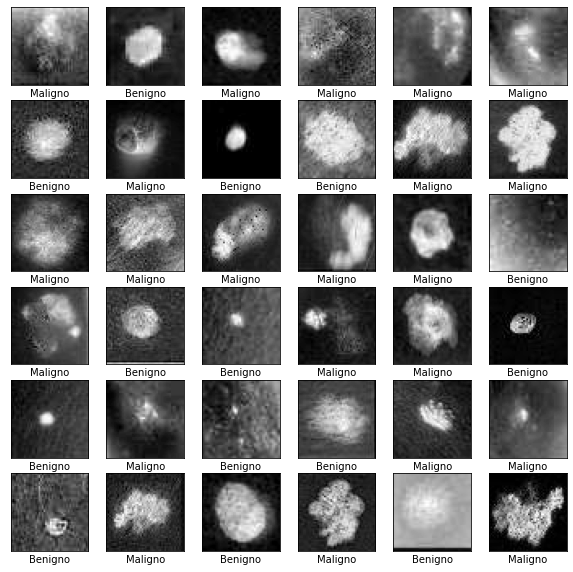

In [15]:
# Muestra las primeras 36 imagenes del conjunto de entrenamiento 
v_tb.plot_img(train_images,train_labels,6,class_names, "../reports/", "train_img")

## (4) MODELO - CNN

In [16]:
EPOCHS= 100
BSIZE = 48
PAT_VAL = 10

EL MEJOR accuracy se alcanzó con la siguientes características:  

Settings:  
Random seed = 54  
%Train = 85%  - % Test = 15%  
%Valid = 20%
----------  
Función de activación --> RELU   (en todas las capas)  
Optimizador --> Adam  
----------  
Una CNN con:  
    - 1 capa convolutiva con 8 neuronas  
    - 1 capa convolutiva con 16 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25   
    - 1 capa convolutiva con 32 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25  
    - 1 Flatten  
    - 1 dense con 32 neuronas  
    - 1 dense con 64 neuronas  
    - 1 dense con 2 (Softmax --> salida)


In [17]:
tf.config.run_functions_eagerly(True)

INPUT_SHAPE = (48,48,1)

model1 = keras.models.Sequential()

# First conv-pool layers - set 1
model1.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), 
activation="relu", padding="valid", input_shape=INPUT_SHAPE))
model1.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model1.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model1.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model1.add(keras.layers.Dropout(rate=0.25))

# Flatten layer
model1.add(keras.layers.Flatten())

# Dense layers
model1.add(keras.layers.Dense(units=32, activation="relu"))
model1.add(keras.layers.Dense(units=64, activation="relu"))
# Output layer
model1.add(keras.layers.Dense(units=2, activation="softmax"))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0

In [18]:
# Compilar el modelo
# Distintos valores probados para el optimizador (*los mejores) : (*adam, *RMSprop, AdaMax, Adadelta, Adagrad)
model1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=PAT_VAL, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=PAT_VAL, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr] 

In [20]:
# Usaremos 20% de la data de entrenamiento para validar el desempeño de la red en cada epoch.
X_train, X_valid, y_train, y_valid = train_test_split(train_images_gr, train_labels, train_size=0.8)
 

In [21]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=20, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               shear_range=0.1,
                               fill_mode='nearest')

In [22]:
# En caso que se quieran guardar en disco las imágenes generadas en cada EPOCH se usa este path
save_path = "../resources/DataAument/Gen_Model"

In [23]:
history = model1.fit(augmenter.flow(X_train, y_train, batch_size=BSIZE
#,save_to_dir=save_path, save_prefix= "t_", save_format = "png"   #Si se quieren guardar en disco
 ),
                    validation_data=augmenter.flow(X_valid, y_valid, batch_size=BSIZE),
                    steps_per_epoch= len(X_train) // BSIZE,
                    epochs=EPOCHS, callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - 1s 189ms/step - loss: 0.7097 - accuracy: 0.4395 - val_loss: 0.6941 - val_accuracy: 0.4808
Epoch 2/100
4/4 [==============================] - 1s 243ms/step - loss: 0.6926 - accuracy: 0.5159 - val_loss: 0.6899 - val_accuracy: 0.5192
Epoch 3/100
4/4 [==============================] - 1s 254ms/step - loss: 0.6817 - accuracy: 0.5541 - val_loss: 0.6885 - val_accuracy: 0.5192
Epoch 4/100
4/4 [==============================] - 1s 185ms/step - loss: 0.6763 - accuracy: 0.5478 - val_loss: 0.6865 - val_accuracy: 0.5192
Epoch 5/100
4/4 [==============================] - 1s 189ms/step - loss: 0.6803 - accuracy: 0.5414 - val_loss: 0.6878 - val_accuracy: 0.5192
Epoch 6/100
4/4 [==============================] - 1s 216ms/step - loss: 0.6711 - accuracy: 0.5478 - val_loss: 0.6789 - val_accuracy: 0.5385
Epoch 7/100
4/4 [==============================] - 1s 277ms/step - loss: 0.6630 - accuracy: 0.6561 - val_loss: 0.6679 - val_accuracy: 0.5769
Epoch 8/100
4

In [25]:
test_loss, test_acc = model1.evaluate(test_images_gr,  test_labels, verbose=2)

print('\nTest accuracy:', round(test_acc,7)*100 , "%")

2/2 - 0s - loss: 0.5225 - accuracy: 0.7826

Test accuracy: 78.26087000000001 %


[INFO] Generando gráfico...


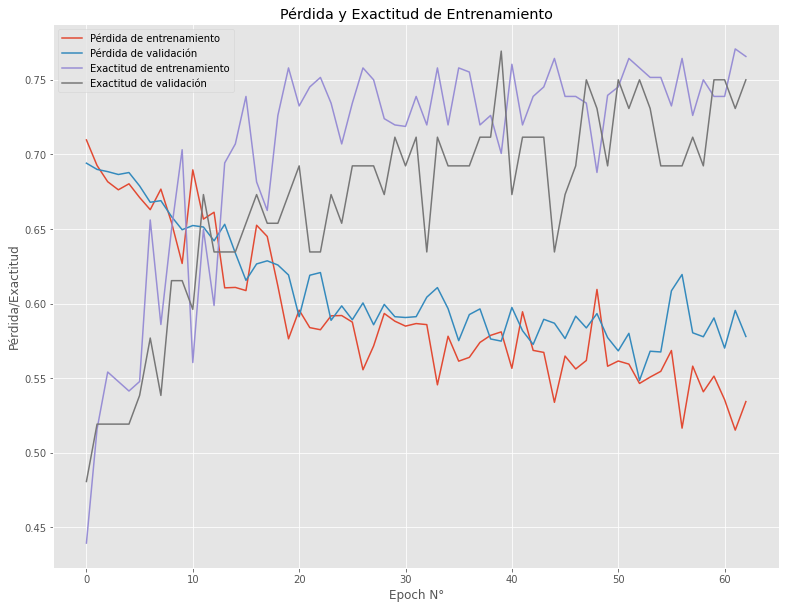

In [44]:
moment=time.localtime()
nfile = 'Grafico_{}_{}-{}-{}'.format(round(test_acc*100000),moment[2],moment[3],moment[4])
v_tb.plot_history(history,"../reports/", test_acc)

### PREDICCIONES

In [45]:
predictions = model1.predict(test_images_gr)

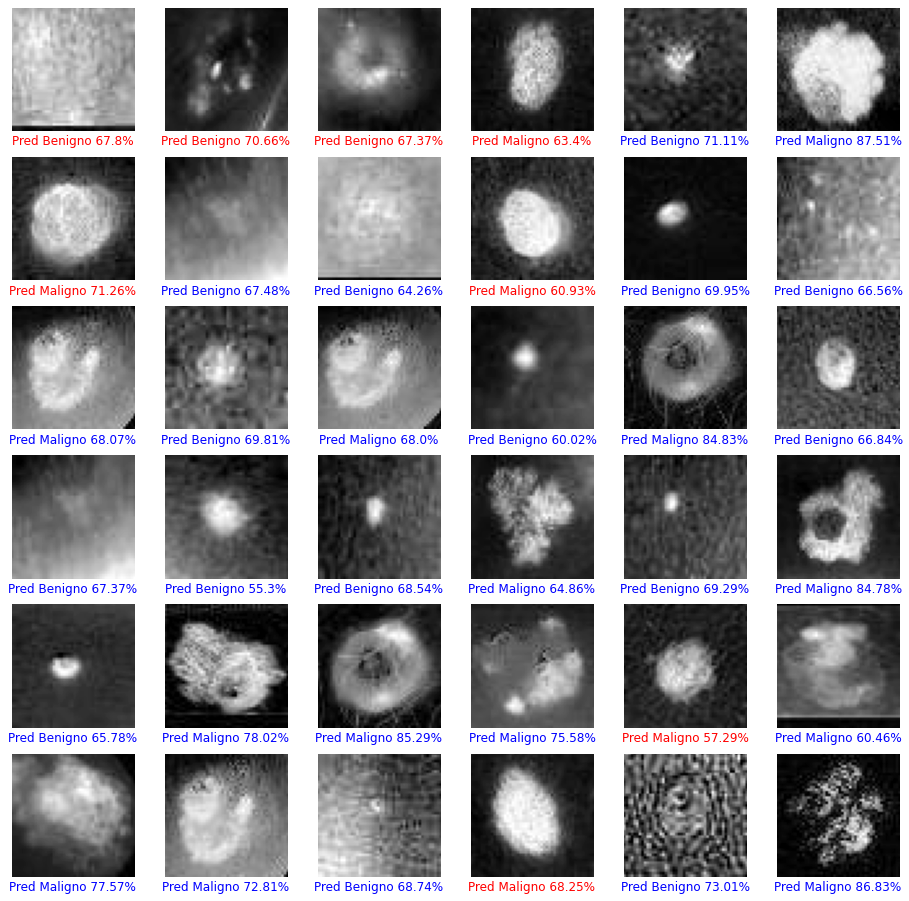

In [46]:
v_tb.plot_test(test_images,test_labels,predictions,6,class_names,"../reports/", "test_results")

### Resultados: Matriz de Confusión y Reporte de Clasificación

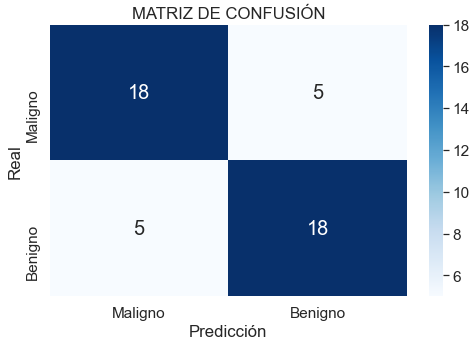

In [47]:
 #Genera la matriz de confusión y la guarda en un archivo. La retorna como dataframe
df_mc= v_tb.mat_confusion(predictions, test_labels, class_names,"../reports/","mat_conf")

In [49]:
# Carga una matriz de confusión ya generada y la muestra.
mat_df = f_tb.cargar_csv("../reports/mat_conf")
mat_df

,Maligno,Benigno
Maligno,18,5
Benigno,5,18


### Reporte de Clasificación

In [52]:
 #Genera el reporte de clasificación y lo guarda en un archivo. Lo retorna como dataframe
 df_rc = v_tb.clasif_repor (predictions, test_labels, class_names, "../reports/", "rep_clasif")

In [53]:
df_rc

,precision,recall,f1-score,support
Maligno,0.782609,0.782609,0.782609,23.000000
Benigno,0.782609,0.782609,0.782609,23.000000
accuracy,0.782609,0.782609,0.782609,0.782609
macro avg,0.782609,0.782609,0.782609,46.000000
weighted avg,0.782609,0.782609,0.782609,46.000000


In [54]:
# Carga un reporte de clasificación ya generado y lo muestra.
clasif_df=f_tb.cargar_csv("../reports/rep_clasif")
clasif_df

,precision,recall,f1-score,support
Maligno,0.782609,0.782609,0.782609,23.000000
Benigno,0.782609,0.782609,0.782609,23.000000
accuracy,0.782609,0.782609,0.782609,0.782609
macro avg,0.782609,0.782609,0.782609,46.000000
weighted avg,0.782609,0.782609,0.782609,46.000000


### GUARDAR EL MODELO

In [55]:
ubicacion ="../modelos"
mod_tb.guardar_modelo(model1, ubicacion, test_acc)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../modelos/Model_0.78261_20-18-20/assets


### CARGAR UN MODELO GUARDADO

In [56]:
ubicacion = "../modelos"
#model_name = "Model_0.82609_16-18-16"
#model_name = "Model_0.76087_20-11-30"
model_name = "Model_0.78261_20-18-20"
modelo_REF = mod_tb.cargar_modelo(ubicacion, model_name)


In [57]:
predictionsA = modelo_REF.predict(test_images_gr)
predictionsB = np.argmax(predictionsA, axis=1)
mcY = confusion_matrix(test_labels, predictionsB)
print('Matriz de confusión')
print(mcY)

Matriz de confusión
[[18  5]
 [ 6 17]]


In [58]:
print(classification_report(test_labels, predictionsB, target_names=class_names))

              precision    recall  f1-score   support

     Maligno       0.75      0.78      0.77        23
     Benigno       0.77      0.74      0.76        23

    accuracy                           0.76        46
   macro avg       0.76      0.76      0.76        46
weighted avg       0.76      0.76      0.76        46



### PRUEBA CON EL MODELO GUARDADO Y CARGADO

In [59]:
relpath = ('../resources/Casos')
nfoto = "f1.png"
foto = relpath + "/"+ nfoto

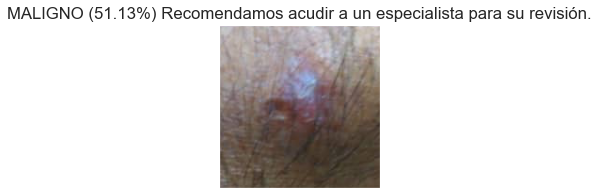

In [60]:
# Predicción mostrando la imagen y el resultado
res  = a_tb.predic_imagen(modelo_REF, foto, class_names,modif=True,mostrar=True, rjson= False)

In [61]:
# Predicción en formato JSON
res  = a_tb.predic_imagen(modelo_REF, foto, class_names,modif=True,mostrar=True, rjson= True)
res

'{"Maligno":{"0":0.5113120079},"Benigno":{"0":0.4886880219}}'